In [45]:
# !pip install tf_keras tensorflow tensorflow-recommenders tensorflow-datasets scann

In [46]:
# Use legacy Keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [47]:
from typing import Dict, Text

import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

RANDOM_STATE = 42

tf.random.set_seed(RANDOM_STATE)

## Preprocess

### Download Datasets

In [48]:
# Download the dataset and cache them as `tfrecord`

ratings_dataset, ratings_dataset_info = tfds.load(
    # Options: '25m-ratings', 'latest-small-ratings', '100k-ratings', '1m-ratings', '20m-ratings'
    name = 'movielens/100k-ratings',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Ratings count:", ratings_dataset.__len__().numpy())

movies_dataset, movies_dataset_info = tfds.load(
    # Options: '25m-movies', 'latest-small-movies', '100k-movies', '1m-movies', '20m-movies'
    name = 'movielens/100k-movies',
    # MovieLense has only the `train` split.
    split = 'train',
    # Include metadata like version, description, homepage, citation, etc.
    with_info = True
)
print(f"Movies count:", movies_dataset.__len__().numpy())

Ratings count: 100000
Movies count: 1682


### Feature Selection

In [49]:
# Feature selection
ratings_dataset = ratings_dataset.map(
    lambda rating: {
        # `user_id` is useful as a user identifier.
        'user_id': rating['user_id'],
        # `movie_id` is useful as a movie identifier.
        'movie_id': rating['movie_id'],
        # `movie_title` is useful as a textual information about the movie.
        'movie_title': rating['movie_title'],
        # `user_rating` shows the user's level of interest to a movie.
        'user_rating': rating['user_rating'],
        # `timestamp` will allow us to model the effect of time.
        'timestamp': rating['timestamp']
    }
)

### Dataset Splitting

In [50]:
# Shuffle the elements of the dataset randomly.
ratings_dataset_shuffled = ratings_dataset.shuffle(
    # The new dataset will be sampled from a buffer window of first `buffer_size`
    # elements of the dataset
    buffer_size = 100_000,
    # The random seed used to create the distribution.
    seed = RANDOM_STATE,
    # `list(dataset.as_numpy_iterator()` yields different result for each call
    # Because reshuffle_each_iteration defaults to True.
    reshuffle_each_iteration = False
)

# Split dataset randomly (80% for training and 20% for validation)
trainset_size: int  = 0.5 * ratings_dataset.__len__().numpy()

ratings_trainset = ratings_dataset_shuffled.take(trainset_size)
ratings_validset = ratings_dataset_shuffled.skip(trainset_size)

print(f"trainset_size:", ratings_trainset.__len__().numpy())
print(f"validset_size:", ratings_validset.__len__().numpy())

trainset_size: 50000
validset_size: 50000


### Categorical Features to Embeddings

In [51]:
USER_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
user_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
user_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['user_id']
    )
)

user_ids            = ['1', '124', 'xxx']
user_ids_mappings   = list(user_id_lookup_layer(user_ids).numpy())
print(f"Lookups for user_ids {user_ids} -> {user_ids_mappings}")


user_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = user_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = USER_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (user_id) in and yields embeddings
user_id_model = tf.keras.Sequential(
    [
        user_id_lookup_layer,
        user_id_embedding_layer
    ]
)

user_ids_embeddings = user_id_model(tf.convert_to_tensor(user_ids))
print(f"Embeddings for user_ids {user_ids} -> {user_ids_embeddings}")

Lookups for user_ids ['1', '124', 'xxx'] -> [79, 899, 0]
Embeddings for user_ids ['1', '124', 'xxx'] -> [[-0.00617684 -0.01510661  0.04721252 -0.02996333 -0.00517017 -0.02561041
   0.02575946 -0.04325232  0.00133885  0.01746913  0.04594481  0.02650649
   0.03635137 -0.02954218 -0.01224468  0.0388358   0.00093381  0.03646778
  -0.03840183  0.00594395  0.02301914 -0.04406687 -0.02819129 -0.00071276
  -0.03348086  0.04923535  0.00855726  0.04194597  0.01321353  0.0084868
   0.00964457 -0.03240247]
 [ 0.04857698 -0.02358506  0.02875826  0.04348486 -0.02120069  0.01740364
   0.04345603  0.00394396  0.01659608  0.02870503 -0.01449173 -0.04752832
  -0.02785654  0.00367572 -0.00492766  0.03212    -0.00223903  0.01579173
   0.00788007  0.0316014   0.01982938 -0.015465    0.04690541  0.02970685
  -0.01070715  0.02551334 -0.04896654 -0.01340976 -0.01845834  0.01990242
   0.04099922 -0.04518945]
 [-0.0038403   0.04254628 -0.02950495 -0.0125524  -0.04475538  0.04743365
  -0.00986848 -0.01488544  0.

In [52]:
MOVIE_ID_EMBEDDING_DIM = 32

# Make a Keras StringLookup layer as the mapping (lookup)
movie_id_lookup_layer = tf.keras.layers.StringLookup(
    mask_token = None,
    # Include the OOV token so the layer can handle categorical values 
    # that are not in the vocabulary and the model can continue to learn 
    # and make recommendations even using features it has not been seen 
    # during vocabulary construction.
    oov_token = "[UNK]",
)

# StringLookup layer is a non-trainable layer and its state (the vocabulary)
# must be constructed and set before training in a step called "adaptation".
movie_id_lookup_layer.adapt(
    ratings_trainset.map(
        lambda x: x['movie_id']
    )
)

movie_ids            = ['1', '124', 'xxx']
movie_ids_mappings   = list(movie_id_lookup_layer(['1', '12', '100', 'xxx']).numpy())
print(f"Lookups for movie_ids {movie_ids} -> {movie_ids_mappings}")


movie_id_embedding_layer = tf.keras.layers.Embedding(
    # Size of the vocabulary
    input_dim = movie_id_lookup_layer.vocabulary_size(),
    # Dimension of the dense embedding
    output_dim = MOVIE_ID_EMBEDDING_DIM
)

# A model that takes raw string feature values (movie_id) in and yields embeddings
movie_id_model = tf.keras.Sequential(
    [
        movie_id_lookup_layer,
        movie_id_embedding_layer
    ]
)

movie_ids_embeddings = movie_id_model(tf.convert_to_tensor(movie_ids))
print(f"Embeddings for movie_ids {movie_ids} -> {movie_ids_embeddings}")

Lookups for movie_ids ['1', '124', 'xxx'] -> [4, 53, 2, 0]
Embeddings for movie_ids ['1', '124', 'xxx'] -> [[ 0.03222071 -0.00941772 -0.04141575 -0.01875787 -0.00621741 -0.0333785
   0.01643541 -0.02580888  0.04659477 -0.02093517 -0.0455995  -0.03799476
   0.03796772  0.03765987  0.04267207  0.00485197  0.04444661 -0.00146191
   0.0390312   0.00631963 -0.00984343 -0.02262664  0.01378013  0.0241977
  -0.03123667 -0.00853509 -0.03163533  0.0092294  -0.00633585 -0.01272366
   0.03751322 -0.0346372 ]
 [ 0.01962464 -0.02454803  0.04552439  0.03938374 -0.00075004  0.00046391
  -0.03530071 -0.04081204  0.03592969 -0.01878206 -0.01711718 -0.04557779
   0.04113627  0.03067937 -0.00672307  0.02493395 -0.01443177 -0.04056663
   0.02646613  0.02233458 -0.02333272  0.04314451 -0.02919654 -0.01174495
   0.04440526 -0.00398811  0.00081426  0.02263928  0.02510283  0.04865429
  -0.01949321  0.01967803]
 [ 0.00613561  0.01393538 -0.00508081 -0.01125779 -0.03077326 -0.04986966
   0.04077008  0.04510694 -

### Textual Features to Embeddings

In [53]:
MOVIE_TITLE_EMBEDDING_DIM = 32

# Keras TextVectorization layer transforms the raw texts into `word pieces` and
# map these pieces into tokens.
movie_title_vectorization_layer = tf.keras.layers.TextVectorization()

movie_title_vectorization_layer.adapt(
    ratings_trainset.map(
        lambda rating: rating['movie_title']
    )
)

# Verify that the tokenization is done correctly
vocabulary = movie_title_vectorization_layer.get_vocabulary()
print(f"Vocabulary -> {vocabulary[:10]}")
print(f"Vectorized 'Postman, The (1997)' -? {movie_title_vectorization_layer('Postman, The (1997)')}")

movie_title_embedding_layer = tf.keras.layers.Embedding(
    input_dim = len(vocabulary),
    output_dim = MOVIE_TITLE_EMBEDDING_DIM,
    # Whether or not the input value 0 is a MASK token.
    # Keras TextVectorization layer builds the vocabulary with MASK token.
    mask_zero = True
)

movie_title_model = tf.keras.Sequential(
    [
       movie_title_vectorization_layer,
       movie_title_embedding_layer,
       # Each title contains multiple words, so we will get multiple embeddings
       # for each title that should be compressed into a single embedding for
       # the text. Models like RNNs, Transformers or Attentions are useful here.
       # However, averaging all the words' embeddings together is also a good
       # starting point.
       tf.keras.layers.GlobalAveragePooling1D()
    ]
)

Vocabulary -> ['', '[UNK]', 'the', '1996', '1997', '1995', '1994', 'of', '1993', 'and']
Vectorized 'Postman, The (1997)' -? [1140    2    4]


### Build the Retrieval (Candidate Generation Phase)

In [54]:
# Query tower
query_model = user_id_model
 
# Candidate tower
candidate_model = movie_id_model
 
 
# Here we only used query and candidate identifiers to buid the towers. This
# corresponds exactly to a classic matrix factorization approach.
# https://ieeexplore.ieee.org/abstract/document/4781121
# However, we can extend `tf.keras.Model` class to an arbitrarily complex model
# including other features and return the final embedding vector at the end.
# For example, by using movie metadata in the candidate tower, we can alleviate
# cold-start problem.
# return tf.concat([
#         self.user_embedding(inputs["user_id"]),
#         self.timestamp_embedding(inputs["timestamp"]),
#         self.normalized_timestamp(inputs["timestamp"])
#     ], axis=1)

In [55]:
# Create implicit ratings for Retieval
retrieval_ratings_trainset = ratings_trainset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)
 
retrieval_ratings_validset = ratings_validset.map(
    lambda rating: {
        'user_id': rating['user_id'],
        'movie_id': rating['movie_id'],
    }
)

In [56]:
# We are using just `movie_id` feature for making the candidates representation
candidates_corpus_dataset = movies_dataset.map(
    lambda movie: movie['movie_id']
)

factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    # dataset of candidate embeddings from which candidates should be retrieved
    candidates = candidates_corpus_dataset.batch(128).map(
        candidate_model
    )
)

In [57]:
# The task computes the metrics and return the in-batch softmax loss.
# Because the metrics range over the entire candidate set, they are usually much
# slower to compute. Consider setting `compute_metrics=False` in Retrieval
# costructor during training to save the time in computing the metrics.
retrieval_task_layer = tfrs.tasks.Retrieval(
    metrics = factorized_top_k_metrics
)

In [58]:
class RetrievalModel(tfrs.models.Model):
    """
        MovieLens candidate generation model
    """
 
    def __init__(
        self,
        query_model: tf.keras.Model,
        candidate_model: tf.keras.Model,
        retrieval_task_layer: tf.keras.layers.Layer,
    ) -> 'RetrievalModel':
        super().__init__()
        self.query_model          = query_model
        self.candidate_model      = candidate_model
        self.retrieval_task_layer = retrieval_task_layer


    def compute_loss(
        self,
        features: Dict[Text, tf.Tensor],
        training: bool = False
    ) -> tf.Tensor:
        user_id  = features["user_id"]
        movie_id = features["movie_id"]

        query_embeddings              = self.query_model(user_id)
        positive_candidate_embeddings = self.candidate_model(movie_id)

        loss = self.retrieval_task_layer(
            query_embeddings,
            positive_candidate_embeddings,
            compute_metrics = not training  # Speed up training
        )
        return loss

In [59]:
OPTIMIZER_STEP_SIZE = 0.1

retrieval_model = RetrievalModel(
    query_model,
    candidate_model,
    retrieval_task_layer
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate = OPTIMIZER_STEP_SIZE)
retrieval_model.compile(optimizer = optimizer)

In [60]:
EPOCHS = 10

# Shuffle the training data for each epoch.
# Batch and cache both the training and evaluation data.
# `cache()` method caches the elements in the dataset in memory. To caches data
# in a file pass the `filename` argument to the method: cache(filename='')
# The first time the dataset is iterated over, its elements will be cached
# either in the specified file or in memory. Subsequent iterations will use the
# cached data.
retrieval_cached_ratings_trainset = retrieval_ratings_trainset.shuffle(100_000).batch(1024).cache()
retrieval_cached_ratings_testset = retrieval_ratings_validset.batch(1024).cache()

history = retrieval_model.fit(
    retrieval_cached_ratings_trainset,
    validation_data = retrieval_cached_ratings_testset,
    validation_freq = 1,
    epochs = EPOCHS
)

Epoch 1/10
49/49 [==============================] - 24s 351ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 6978.0915 - regularization_loss: 0.0000e+00 - total_loss: 6978.0915 - val_factorized_top_k/top_1_categorical_accuracy: 0.0018 - val_factorized_top_k/top_5_categorical_accuracy: 0.0135 - val_factorized_top_k/top_10_categorical_accuracy: 0.0290 - val_factorized_top_k/top_50_categorical_accuracy: 0.1422 - val_factorized_top_k/top_100_categorical_accuracy: 0.2569 - val_loss: 5549.0918 - val_regularization_loss: 0.0000e+00 - val_total_loss: 5549.0918
Epoch 2/10
49/49 [==============================] - 8s 176ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00

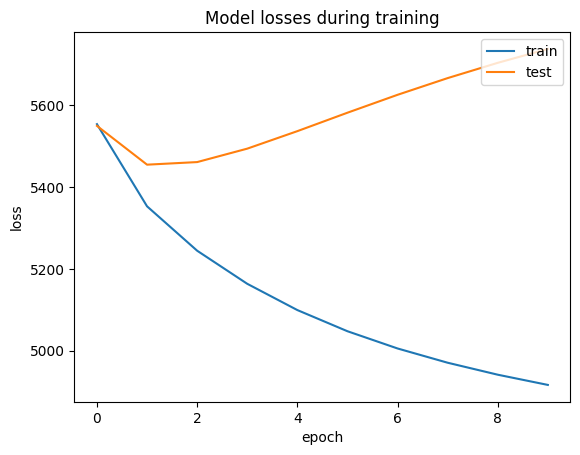

In [61]:
# Plot loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model losses during training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [62]:
scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    retrieval_model.query_model,
    k = 10,
)

scann_layer.index_from_dataset(
  tf.data.Dataset.zip(
      (
          candidates_corpus_dataset.batch(100),
          candidates_corpus_dataset.batch(100).map(retrieval_model.candidate_model)
      )
  )
)

user_id = '41'
afinity_scores, movie_ids = scann_layer(
    tf.constant([user_id])
)

print(f"Recommendations for user {user_id} using ScaNN: {movie_ids[0, :5]} (Confidences: {afinity_scores[0, :5]})")
print(movie_ids.shape)

2024-08-27 17:15:46.519273: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-08-27 17:15:46.523157: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:89] PartitionerFactory ran in 3.817704ms.


Recommendations for user 41 using ScaNN: [b'196' b'969' b'211' b'215' b'174'] (Confidences: [3.8742657 3.7174191 3.6267076 3.6018486 3.5713873])
(1, 5)
